### SHGF Forney-Style Factor Graph
<img src="figures/SHGF-FFG.png">

# Retrieve research results (verification)

To inspect the reported research results you must install the following julia packages:
**JLD**, **PGFPlotsX**, **Plots**, **LaTeXStrings**

Notational conventions: prefixes **m** and **v** denote mean and variance of the random variables respectively.

For a sake of brevity, throughout the code we use $x$ and $z$ instead of $x^{(1)}$ and $x^{(2)}$ respectively.

In [11]:
using JLD
using SparseArrays

rfilename = "dump/results_verification_analytic_mixture.jld"
resultsJLD = JLD.load(rfilename)
results = resultsJLD["results"];
datasetJLD = JLD.load("dump/dataset.jld")
dataset = datasetJLD["dataset"];

In [21]:
index = 10

mz, vz, mx, vx, ms, mω, vω,fe = results[index]["mz"], results[index]["vz"], results[index]["mx"], results[index]["vx"], results[index]["ms"], results[index]["mω"], results[index]["vω"], results[index]["fe"]
reals = dataset[index]["reals"]
obs = dataset[index]["obs"]
upper_rw = dataset[index]["rw"]
switches = dataset[index]["switches"]
omegas = dataset[index]["ωs"]
n_samples = length(obs);

500

In [22]:
using PGFPlotsX, Plots
using LaTeXStrings

pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

3-element Array{String,1}:
 "\\usepgfplotslibrary{fillbetween}"
 "\\usepgfplotslibrary{fillbetween}"
 "\\usepgfplotslibrary{fillbetween}"

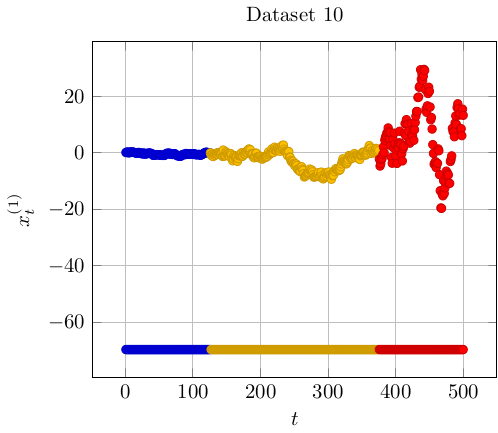

In [30]:
categories = [x[2] for x in findmax.(ms)]
maxup = maximum(obs) + 3.0
mindown = minimum(obs) - 50.0

axis1 = @pgf Axis({xlabel=L"t",
           ylabel=L"x_t^{(1)}",
        legend_pos = "south east",
        grid = "major",
        title="Dataset $(index)",
    },
    Plot(
        {only_marks, scatter, scatter_src = "explicit"},
        Table(
            {x = "x", y = "y", meta = "col"},
             x = collect(1:n_samples), y = mindown*ones(n_samples), col = categories
        ),
    ),
    Plot(
        {only_marks,scatter,scatter_src = "explicit"},
        Table(
            {x = "x", y = "y", meta = "col"},
             x = collect(1:n_samples), y = obs, col = switches
        ),
    ),
)

#pgfsave("figures/verification_results_mixture_recovered_switches.tikz", axis1)

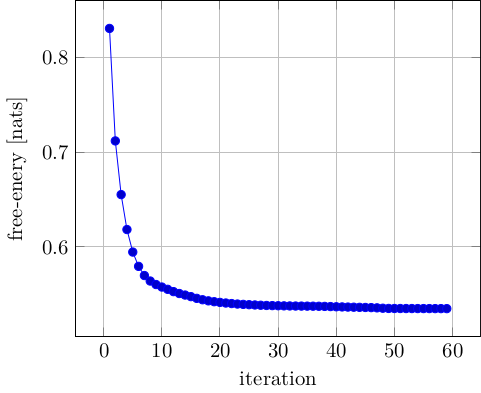

In [25]:
FE = zeros(100)
for i in 1:n_datasets
    fe = results[i]["fe"] ./ n_samples
    FE += fe
end
FE ./= (n_datasets)


axis2 = @pgf Axis({xlabel=L"t",
           ylabel=L"x_t^{(2)}",
        legend_pos = "north east",
    },
    Plot({no_marks,color="blue"},Coordinates(collect(1:n_samples), mz)),
    LegendEntry("estimate"),
    Plot({ "name path=f", no_marks,color="blue",opacity=0.2 }, Coordinates(collect(1:n_samples), mz .+  sqrt.(vz))),
    Plot({ "name path=g", no_marks, color="blue",opacity=0.2}, Coordinates(collect(1:n_samples), mz .-  sqrt.(vz))),
    Plot({ thick, color = "blue", fill = "blue", opacity = 0.2 },
               raw"fill between [of=f and g]"),

    Plot({no_marks,color="green"},Coordinates(collect(1:n_samples), upper_rw)),
    LegendEntry("ground truth"),
)
pgfsave("figures/verification_results_mixture_recovered_upper_layer.tikz", axis2)

axis3 = @pgf Axis({xlabel="iteration",
           ylabel="free-enery [nats]",
        legend_pos = "north east",
        grid = "major",
    },
    Plot(Coordinates(collect(1:59),FE[2:60]))
)
#pgfsave("figures/verification_results_mixture_free_energy.tikz", axis3)


### Root Mean Squared Error 

In [20]:
using StatsBase
sum([rmsd(results[i]["mω"], Float64.(dataset[i]["ωs"]), normalize=true) for i in 1:n_datasets])/n_datasets

0.1517533993297162

# Implemetation

To run the inference, the following packages must be installed:
**ForneyLab**, **GCV**, **ProgressMeter**

In [34]:
using ForneyLab
using GCV
include("sgcv/SGCV.jl")
using Main.SGCV
include("compatibility.jl") # resolves compatibility issues with ForneyLab
using SparseArrays
using ProgressMeter;

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278
┌ Info: Precompiling GCV [06ce179b-585a-447b-bf15-ae03815b35cb]
└ @ Base loading.jl:1278
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [ ]:
# Auxialry function for graph initializtion
pad(sym::Symbol, t::Int) = sym*:_*Symbol(lpad(t,3,'0')) # Left-pads a number with zeros, converts it to symbol and appends to sym

In [ ]:
# Function for generating graph and message-passing (MP) algorithm
function generate_mp(ndim, n_samples)
    # Initialize FFG
    fg = FactorGraph()
    z = Vector{Variable}(undef, n_samples)
    x = Vector{Variable}(undef, n_samples)
    y = Vector{Variable}(undef, n_samples)
    s = Vector{Variable}(undef, n_samples)
    @RV A ~ Dirichlet(ones(ndim, ndim))
    @RV ω ~ GaussianMeanPrecision(placeholder(:mω, dims=(ndim, )), placeholder(:wω, dims=(ndim, ndim)))
    @RV [id=pad(:z,1)] z[1] ~ GaussianMeanPrecision(placeholder(:mz_prior1), placeholder(:wz_prior1))
    @RV [id=pad(:x,1)] x[1] ~ GaussianMeanPrecision(placeholder(:mx_prior1), placeholder(:wx_prior1))
    @RV [id=pad(:y,1)] y[1] ~ GaussianMeanPrecision(x[1], placeholder(:wy_prior1))
    @RV [id=pad(:s,1)] s[1] ~ ForneyLab.Categorical(ones(ndim) ./ ndim)
    placeholder(y[1], :y, index = 1)
    for t in 2:n_samples
        @RV [id=pad(:s,t)] s[t] ~ Transition(s[t-1], A)
        @RV [id=pad(:z,t)] z[t] ~ GaussianMeanPrecision(z[t - 1], placeholder(pad(:wz_transition, t)))
        @RV [id=pad(:x,t)] x[t] ~ SwitchingGaussianControlledVariance(x[t - 1], z[t],ones(ndim),ω,s[t])
        @RV [id=pad(:y,t)] y[t] ~ GaussianMeanPrecision(x[t], placeholder(pad(:wy_transition, t)))
        placeholder(y[t], :y, index = t)
    end
    # Initialize recognition distribution
    q = PosteriorFactorization(x, z ,s, A, ω, ids=[:X :Z :S :A :Ω])
    # Create algorithm
    algo = messagePassingAlgorithm(free_energy=true)
    src_code = algorithmSourceCode(algo, free_energy=true);
    return src_code
end

In [ ]:
# Function for running MP-based inference
function mp(obs;
    ndims,
    n_its = 100,
    wy_prior1 = 1.0,
    κ_m_prior = ones(ndims),
    ω_m_prior = omegas,
    κ_w_prior =  huge .* diageye(ndims),
    ω_w_prior = 1.0 .* diageye(ndims),
    z_m_prior = 0.0,
    z_w_prior = 10.0,
    x_m_prior = 0.0,
    x_w_prior = 1.0,
    x_x_m_prior = zeros(ndims),
    x_x_w_prior = 1.0*diageye(ndims),
    z_z_m_prior = zeros(ndims),
    z_z_w_prior = 10.0*diageye(ndims),
    z_w_transition_prior = 1000.0,
    y_w_transition_prior =  1/mnv,
)

    # Initialize dictionary to store marginal distributions
    marginals = Dict()
    marginals[:A] = ProbabilityDistribution(ForneyLab.MatrixVariate, Dirichlet, a=ones(ndims, ndims))
    marginals[:κ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m = κ_m_prior, w = κ_w_prior)
    marginals[:ω] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m = ω_m_prior, w = ω_w_prior)
    marginals[pad(:z,1)] = vague(GaussianMeanPrecision)
    marginals[pad(:x,1)] = vague(GaussianMeanPrecision)
    marginals[pad(:s,1)] = vague(Categorical, ndims)
    for t = 2:n_samples
        marginals[pad(:z,t)] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m = z_m_prior, w = z_w_prior)
        marginals[pad(:x,t)] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m = x_m_prior, w = x_w_prior)
        marginals[pad(:s,t)] = ProbabilityDistribution(Categorical, p = ones(ndims) ./ ndims)
        marginals[pad(:s,t)*:_*pad(:s,t-1)] = ProbabilityDistribution(Contingency,p=ones(ndims, ndims) ./ ndims)
        marginals[pad(:z,t)*:_*pad(:z,t-1)] = ProbabilityDistribution(ForneyLab.Multivariate,GaussianMeanPrecision, m = z_z_m_prior, w = z_z_w_prior)
        marginals[pad(:x,t)*:_*pad(:x,t-1)] = ProbabilityDistribution(ForneyLab.Multivariate,GaussianMeanPrecision, m = x_x_m_prior, w = x_x_w_prior)
    end
    
    # Initialize dicitionary to store observations and priors
    data = Dict()
    data[:y] = obs
    data[:mz_prior1] = z_m_prior
    data[:wz_prior1] = z_w_prior
    data[:mx_prior1] = x_m_prior
    data[:wx_prior1] = x_w_prior
    data[:wy_prior1] = wy_prior1

    data[:mω] = ω_m_prior
    data[:wω] = ω_w_prior
    for t = 1:n_samples
        data[pad(:wz_transition, t)] = z_w_transition_prior
        data[pad(:wy_transition, t)] = y_w_transition_prior
    end

    # Initialize array to store free-energy values
    fe = Vector{Float64}(undef, n_its)
    
    # MP loop
    for i = 1:n_its

        stepX!(data, marginals)
        stepS!(data, marginals)
        stepA!(data, marginals)
        stepZ!(data, marginals)
        stepΩ!(data, marginals)

        fe[i] = freeEnergy(data, marginals)
    end

    # Extract inferred marginals
    mz = [ForneyLab.unsafeMean(marginals[pad(:z,t)]) for t=1:n_samples]
    vz = [ForneyLab.unsafeVar(marginals[pad(:z,t)]) for t=1:n_samples]
    mx = [ForneyLab.unsafeMean(marginals[pad(:x,t)]) for t=1:n_samples]
    vx = [ForneyLab.unsafeVar(marginals[pad(:x,t)]) for t=1:n_samples]
    ms = [ForneyLab.unsafeMean(marginals[pad(:s,t)]) for t=1:n_samples]
    mω = ForneyLab.unsafeMean(marginals[:ω])
    vω = ForneyLab.unsafeCov(marginals[:ω])
    return mz,vz,mx,vx,ms, mω, vω, fe
end

In [9]:
# Generate data (we used 42 as a Random seed)
include("generator.jl")

In [ ]:
# Generate MP algorithm
code = generate_mp(n_cats, n_samples)
eval(Meta.parse(code))

In [31]:
# Dictionary for storing the results
results = Dict()

@showprogress "Datasets" for i in 1:n_datasets
    obs = dataset[i]["obs"]
    mnv = dataset[i]["nv"]
    omegas = dataset[i]["ωs"] .+ sqrt(1.0)*randn(length(dataset[i]["ωs"]))
    try
        mz,vz,mx,vx,ms, mω, vω,fe = mp(obs, ndims=n_cats, ω_m_prior=omegas,
                                      ω_w_prior=diageye(n_cats),
                                      y_w_transition_prior=1/mnv)
        results[i] = Dict("mz" => mz, "vz" => vz,
                          "mx" => mx, "vx" => vx,
                          "ms" => ms, "fe" => fe,
                          "mω" => mω, "vω" => vω,
                          "ωprior" => omegas)
    catch e
           println("Failed $(i)")
    end
end

LoadError: LoadError: UndefVarError: @showprogress not defined
in expression starting at In[31]:4

In [ ]:
# Saving results and data
# You can use the saved files inside "Retrieve research results" section
rfilename = "your_rfilename.jld"
dfilename = "your_dfilename.jld"
JLD.save(rfilename, "results", results)
JLD.save(dfilename, "dataset", dataset)